In [ ]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
BASE_DIR = '/content/drive/MyDrive/7th Sem/DL/Image Captioning/Images-20241006T055258Z-001/image'
WORKING_DIR = '/content/drive/MyDrive/7th Sem/DL/Image Captioning/captions.txt'

In [ ]:
model = VGG16()
# restructure the model
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
# summarize
print(model.summary())

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 134,260,544 (512.16 MB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
features = {}


for img_name in tqdm(os.listdir(BASE_DIR)):
    # load the image from file
    img_path = BASE_DIR + '/' + img_name

    image = load_img(img_path, target_size=(224, 224))
    # convert image pixels to numpy array
    image = img_to_array(image)
    # reshape data for model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # preprocess image for vgg
    image = preprocess_input(image)
    # extract features
    feature = model.predict(image, verbose=0)
    # get image ID
    image_id = img_name.split('.')[0]
    # store feature
    features[image_id] = feature

  0%|          | 0/2000 [00:00<?, ?it/s]

In [ ]:
image_id = img_name.split('.')[0]

In [ ]:
print(feature)

[[0.08800274 0.         1.8428844  ... 0.         2.5366704  5.157302  ]]


In [ ]:
pickle.dump(features, open(os.path.join(WORKING_DIR, 'features.pkl'), 'wb'))


In [ ]:
with open(os.path.join(WORKING_DIR, 'features.pkl'), 'rb') as f:
    features = pickle.load(f)

In [ ]:
with open(os.path.join(WORKING_DIR, 'captions.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()

In [ ]:
import os
print(os.listdir(WORKING_DIR))

['captions.txt', 'features.pkl', 'best_model.h5']


In [ ]:
mapping = {}
# process lines
for line in tqdm(captions_doc.split('\n')):
    # split the line by comma(,)
    tokens = line.split(',')

    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    # remove extension from image ID
    image_id = image_id.split('.')[0]
    # convert caption list to string
    caption = " ".join(caption)

    # create list if needed
    if image_id not in mapping:
        mapping[image_id] = []
    # store the caption
    mapping[image_id].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

In [ ]:
print(mapping[image_id])

['A man in a pink shirt climbs a rock face', 'A man is rock climbing high in the air .', 'A person in a red shirt climbing up a rock face covered in assist handles .', 'A rock climber in a red shirt .', 'A rock climber practices on a rock climbing wall .']


In [ ]:
print(tokens)

['']


In [ ]:
len(mapping)


8091

In [ ]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # take one caption at a time
            caption = captions[i]
            # preprocessing steps
            # convert to lowercase
            caption = caption.lower()
            # delete digits, special chars, etc.,
            caption = caption.replace('[^A-Za-z]', '')
            # delete additional spaces
            caption = caption.replace('\s+', ' ')
            # add start and end tags to the caption
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption

<>:12: SyntaxWarning: invalid escape sequence '\s'
<>:12: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-3802969776.py:12: SyntaxWarning: invalid escape sequence '\s'
  caption = caption.replace('\s+', ' ')


In [ ]:
mapping['1000268201_693b08cb0e']


['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [ ]:
clean(mapping)

In [ ]:
mapping['1000268201_693b08cb0e']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

In [ ]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [ ]:
len(all_captions)


40455

In [ ]:
all_captions[:10]


['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [ ]:
vocab_size

8485

In [ ]:
# get maximum length of the caption available
max_length = max(len(caption.split()) for caption in all_captions)
max_length

35

In [ ]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

In [ ]:
print(len(test))

810


In [ ]:
# create data generator to get data in batch (avoids session crash)
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            # Only process if the image ID exists in features
            if key in features:
                n += 1
                captions = mapping[key]
                # process each caption
                for caption in captions:
                    # encode the sequence
                    seq = tokenizer.texts_to_sequences([caption])[0]
                    # split the sequence into X, y pairs
                    for i in range(1, len(seq)):
                        # split into input and output pairs
                        in_seq, out_seq = seq[:i], seq[i]
                        # pad input sequence
                        in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                        # encode output sequence
                        out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

                        # store the sequences
                        X1.append(features[key][0])
                        X2.append(in_seq)
                        y.append(out_seq)
                if n == batch_size:
                    X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                    yield [X1, X2], y
                    X1, X2, y = list(), list(), list()
                    n = 0
            else:
                print(f"Warning: Image ID {key} not found in features and will be skipped.")

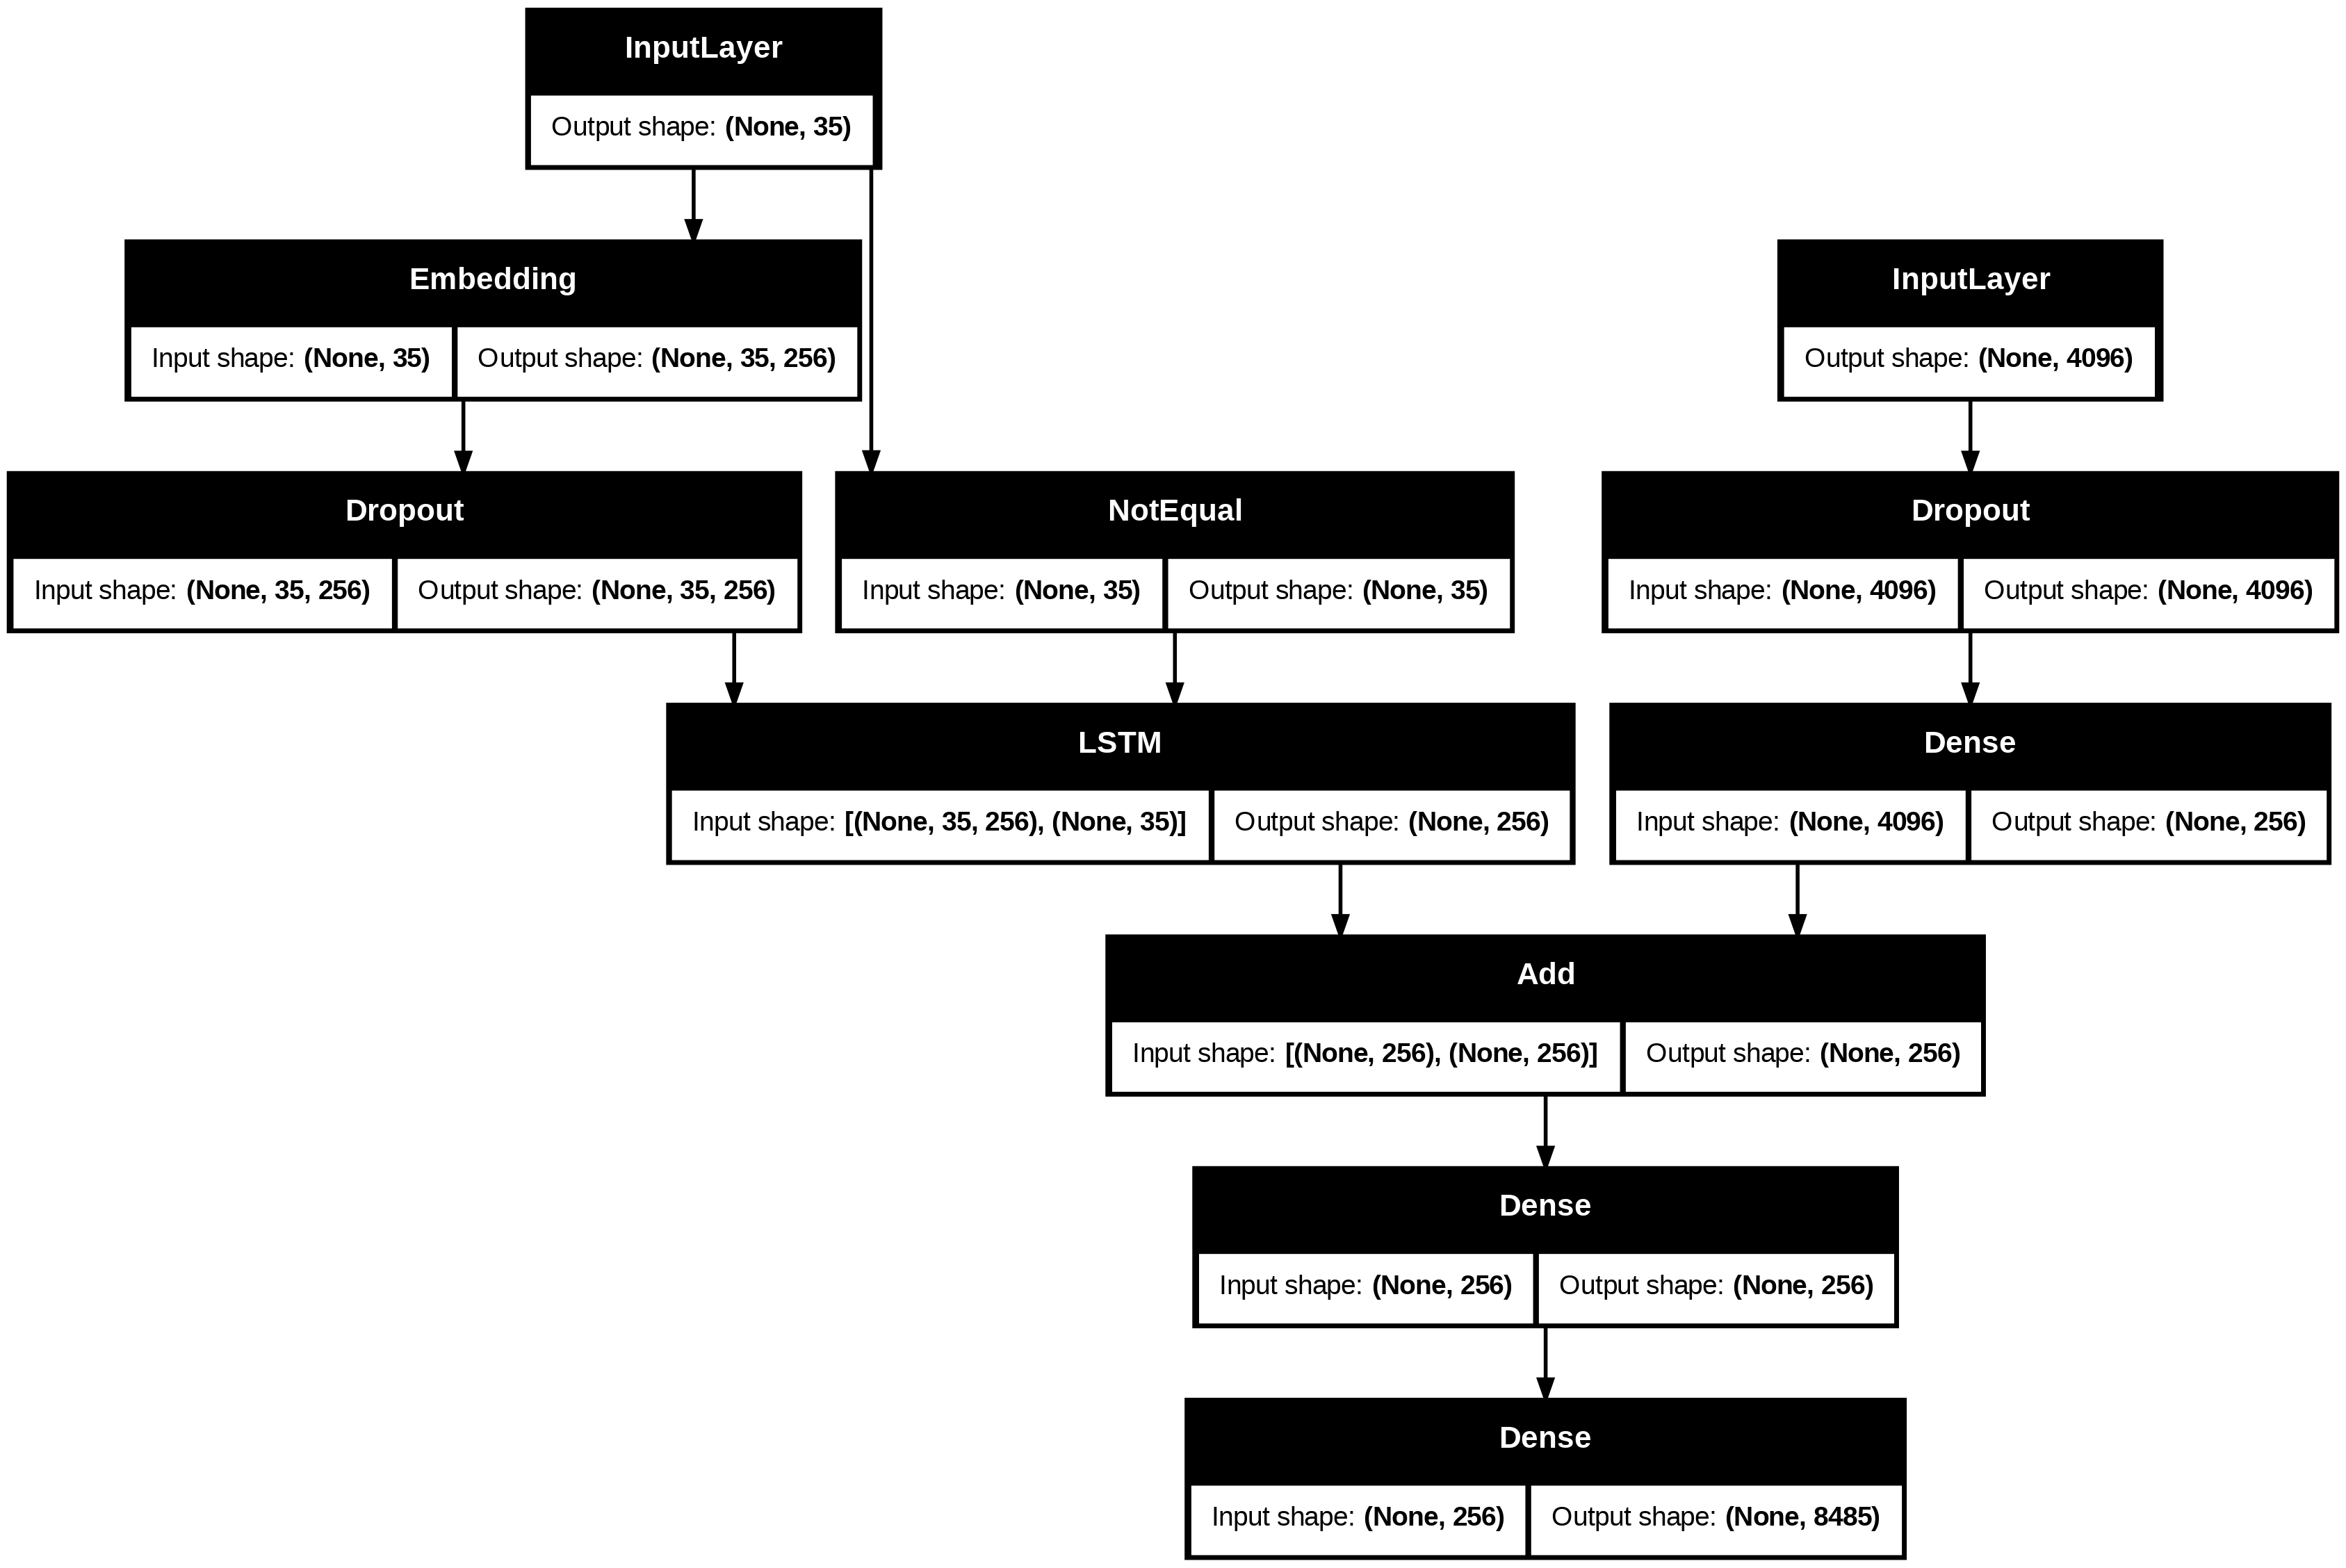

In [ ]:
# encoder model
# image feature layers
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
# sequence feature layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# plot the model
plot_model(model, show_shapes=True)

In [ ]:
# create data generator to get data in batch (avoids session crash)
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            # Only process if the image ID exists in features
            if key in features:
                n += 1
                captions = mapping[key]
                # process each caption
                for caption in captions:
                    # encode the sequence
                    seq = tokenizer.texts_to_sequences([caption])[0]
                    # split the sequence into X, y pairs
                    for i in range(1, len(seq)):
                        # split into input and output pairs
                        in_seq, out_seq = seq[:i], seq[i]
                        # pad input sequence
                        in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                        # encode output sequence
                        out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

                        # store the sequences
                        X1.append(features[key][0])
                        X2.append(in_seq)
                        y.append(out_seq)
                if n == batch_size:
                    X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                    yield [X1, X2], y
                    X1, X2, y = list(), list(), list()
                    n = 0
            else:
                print(f"Warning: Image ID {key} not found in features and will be skipped.")

In [ ]:
model.save(WORKING_DIR+'/best_model.h5')


In [ ]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [ ]:
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break

    return in_text

In [ ]:
from nltk.translate.bleu_score import corpus_bleu
from tqdm.notebook import tqdm
import tensorflow as tf

# ensure eager execution for mask safety
tf.config.run_functions_eagerly(True)

actual, predicted = [], []

# only valid keys (features ∩ captions)
valid_keys = set(mapping.keys()).intersection(set(features.keys()))
test_valid = [k for k in test if k in valid_keys]

print(f"Valid images available for evaluation: {len(valid_keys)}")
print(f"Evaluating on {len(test_valid)} test images...")

for key in tqdm(test_valid):
    try:
        captions = mapping[key]
        y_pred = predict_caption(model, features[key], tokenizer, max_length)
        actual_captions = [caption.split() for caption in captions]
        actual.append(actual_captions)
        predicted.append(y_pred.split())
    except Exception as e:
        print(f"⚠️ Skipped {key} due to error: {e}")
        continue

print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))


Valid images available for evaluation: 2000
Evaluating on 215 test images...


  0%|          | 0/215 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


BLEU-1: 0.027778
BLEU-2: 0.000000


/usr/local/lib/python3.12/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.12/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.12/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    # load the image
    # image_name = "1001773457_577c3a7d70.jpg"
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, image_name) # Corrected path
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

---------------------Actual---------------------
startseq black and cream dog run through field in front of blue house endseq
startseq black dog and white dog run across field behind house endseq
startseq two dogs running in field in front of house endseq
startseq two dogs together in field of grass within sight of beautiful home endseq
startseq two large dogs are running off together through the field endseq
--------------------Predicted--------------------
startseq awkwardly awkwardly awkwardly awkwardly awkwardly awkwardly awkwardly awkwardly awkwardly awkwardly awkwardly awkwardly awkwardly awkwardly awkwardly awkwardly awkwardly awkwardly awkwardly awkwardly awkwardly awkwardly awkwardly awkwardly awkwardly awkwardly awkwardly awkwardly awkwardly awkwardly awkwardly awkwardly awkwardly awkwardly awkwardly


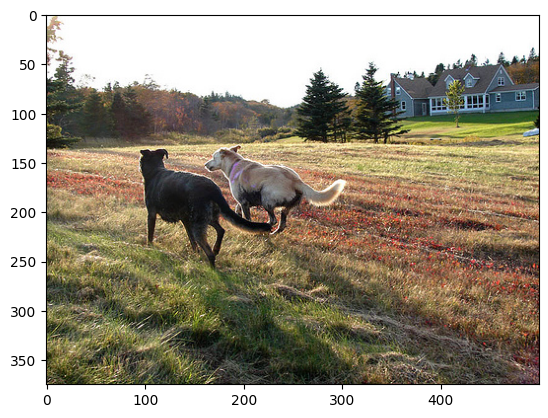

In [ ]:
generate_caption("2957071266_1b40ec7d96.jpg")

---------------------Actual---------------------
startseq boy with stick kneeling in front of goalie net endseq
startseq child in red jacket playing street hockey guarding goal endseq
startseq young kid playing the goalie in hockey rink endseq
startseq young male kneeling in front of hockey goal with hockey stick in his right hand endseq
startseq "hockey goalie boy in red jacket crouches by goal with stick ." endseq
--------------------Predicted--------------------
startseq worried worried worried worried worried worried worried worried worried worried worried worried worried worried worried worried worried worried worried worried worried worried worried worried worried worried worried worried worried worried worried worried worried worried worried


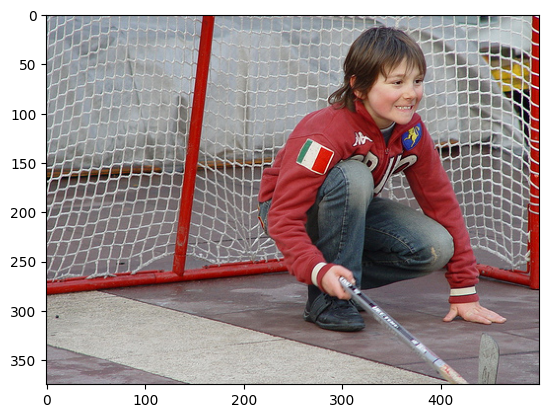

In [ ]:
generate_caption("103106960_e8a41d64f8.jpg")

